In [1]:
import torch
import json

import pandas as pd
import matplotlib.pyplot as plt

from transformers import OPTForCausalLM, AutoTokenizer
from datasets import load_dataset, Dataset

from data_utils import (
    load_glue_datasets,
    load_hans_dataset,
    load_mnli_mismatched_dataset,
    load_paws_qqp_dataset,
    load_cola_ood_dataset,
    task_to_keys
)
from context_utils import create_few_shot_context

In [2]:
# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Tokenizer + Models

In [3]:
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-125m") # tokenizer
teacher_model = OPTForCausalLM.from_pretrained("facebook/opt-125m") # teacher model
student_model = OPTForCausalLM.from_pretrained("facebook/opt-125m") # student model

## Datasets

In [4]:
data_set_used='mnli'
datasets, labels, num_labels = load_glue_datasets(data_set_used)

In [39]:
def create_batch_token(
    dataset_name, datasets, tokenizer, num_shots=1, device = 'cpu', split='train', len_subset=300
):
    batch_tokens = []
    batch_strings = []
    datasets = datasets[split]
    for i in range(0, len_subset, num_shots):
        if split == 'train':
            context, student_context, indices = create_few_shot_context(
                dataset_name,
                datasets,
                num_shots,
                teacher_description="Think logically. Label the following sentences as entailment or contradiction.",
                from_indices=list(range(i, i + num_shots)),
                balanced=True
            )
            token_data= {
                'context':(tokenizer(context, return_tensors="pt")).to(device),
                'query':(tokenizer(student_context, return_tensors="pt")).to(device)
            }
            string_data = {
                'context':context,
                'query':student_context
            }
        else:
            context, student_context, indices = create_few_shot_context(
                dataset_name,
                datasets,
                num_shots,
                from_indices=list(range(i, i + num_shots))
            )
            token_data = (tokenizer(student_context, return_tensors="pt")).to(device)
            string_data = student_context
        batch_tokens.append(token_data)
        batch_strings.append(string_data)
    return batch_tokens, batch_strings

train_data_tokens, train_data_strings = create_batch_token(
    data_set_used, datasets, num_shots=4, tokenizer=tokenizer, device=device
)
student_prompt_tokens, student_prompt_strings = create_batch_token(
    data_set_used, datasets, num_shots=1, tokenizer=tokenizer, device=device, split= 'validation_matched'
)


In [41]:
# User for testing
# teacher_inputs = train_data_tokens[0]['context'].to(device)

# teacher_outputs = teacher_model.generate(
#     **teacher_inputs,
#     max_length=teacher_inputs['input_ids'].shape[-1] + 2
# ).to(device)
# decoded_output = tokenizer.decode(teacher_outputs[0], skip_special_tokens=True)

# print(f"Teacher input: {train_data_strings[0]['context']}")
# print(f"Teacher output: {decoded_output}")

In [46]:
# Assuming `losses` is the list of epoch losses returned from the `train` function
def plot_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, marker='o', linestyle='-', color='b')
    plt.title('Training Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()

Epoch 1, Total Loss: 1.7185195706551895
Epoch 2, Total Loss: 0.7446412709541619
Total loss : 1.4892825419083238


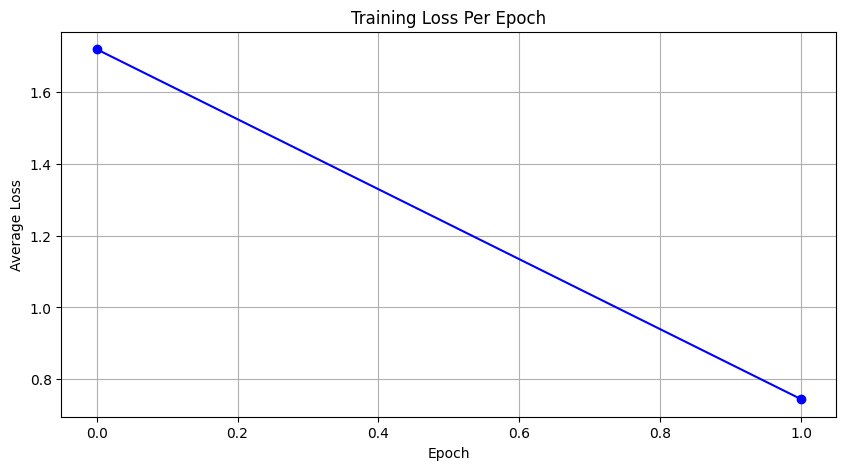

In [47]:
def train(data, epochs=10, batch_size=16, device='cpu'):
    student_model.to(device)
    teacher_model.to(device)
    
    student_model.train()
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=0.001)
    epoch_losses = []


    for epoch in range(epochs):
        total_loss = 0
        num_batches = len(data) // batch_size 
        
        for i in range(num_batches):
            batch_loss = 0
            for j in range(batch_size):
                index = i * batch_size + j
                
                teacher_inputs = data[index]['context'].to(device)
                student_inputs = data[index]['query'].to(device)
                                
                teacher_outputs = teacher_model.generate(
                    **teacher_inputs,
                    max_length=teacher_inputs['input_ids'].shape[-1] + 2,
                    output_scores=True,
                    return_dict_in_generate=True
                )
                teacher_probs = torch.nn.functional.softmax(teacher_outputs.scores[0], dim=-1)
                
                student_logits = student_model(**student_inputs).logits
                student_probs = torch.nn.functional.softmax(student_logits[:, -1, :], dim=-1)
                
                kl_divergence = torch.nn.functional.kl_div(student_probs.log(), teacher_probs, reduction='batchmean')
                
                optimizer.zero_grad()
                kl_divergence.backward()
                optimizer.step()

                batch_loss += kl_divergence.item()

            # Average loss for the batch
            batch_loss /= batch_size
            total_loss += batch_loss
            # print(f"Epoch {epoch + 1}, Batch {i + 1}, Average Loss: {batch_loss}")


        # Average loss for the epoch
        epoch_loss = total_loss / num_batches
        epoch_losses.append(epoch_loss)

        print(f"Epoch {epoch + 1}, Total Loss: {epoch_loss}")
        
    print(f"Total loss : {total_loss/epochs}")
    plot_losses(epoch_losses)
    # torch.save(student_model, './models/student.pth')


train(train_data_tokens, device=device)


In [49]:
def predict(model, source, target=None, device='cpu'):
    predict = []
    for token in source:
        output = model.generate(**token, max_length=token['input_ids'].shape[-1] + 1).to(device)
        decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
        predicted_label = decoded_output.split("Label:")[-1].strip().split('.')[0].strip()
        predict.append(predicted_label)
        
    return predict

student_prompt_tokens, student_prompt_strings = create_batch_token(
    data_set_used, datasets, num_shots=1, tokenizer=tokenizer, device=device, split='validation_matched'
    )
prediction = predict(student_model, student_prompt_tokens, device=device)  


In [54]:
# Use for testing
# student_inputs = student_prompt_tokens[0].to(device)

# student_outputs = student_model.generate(
#     **student_inputs,
#     max_length=student_inputs['input_ids'].shape[-1] + 1
# ).to(device)
# decoded_output = tokenizer.decode(student_outputs[0], skip_special_tokens=True)

In [50]:
prediction

['contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contradiction contradiction',
 'contra